In [1]:
print()

Loaded merged file rows: 973818
After dropna(date) rows: 973818
Dropped exact duplicates: 11 rows
Filtered negative ages: 0 rows
After aggregation (state-district-month) rows: 4207 enrollment_sum: 5319541
NaN counts per feature (monthly): {'lag_1': 790, 'lag_2': 790, 'rolling_mean_3': 790, 'rolling_std_3': 0, 'state_avg': 0, 'district_state_ratio': 0}
Monthly modeling dataset shape (after dropna): (3417, 13)
Enrollment sum raw -> monthly -> modeling: 5319541 5319541 4658235
Saved df_monthly_processed.csv and df_monthly_model_ready.csv to reports for inspection
Train: (1855, 6), Val: (783, 6), Test: (779, 6)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 1855, number of used features: 6
[LightGBM] [Info] Start training from score 7.385008
Training until validation scores don't improv

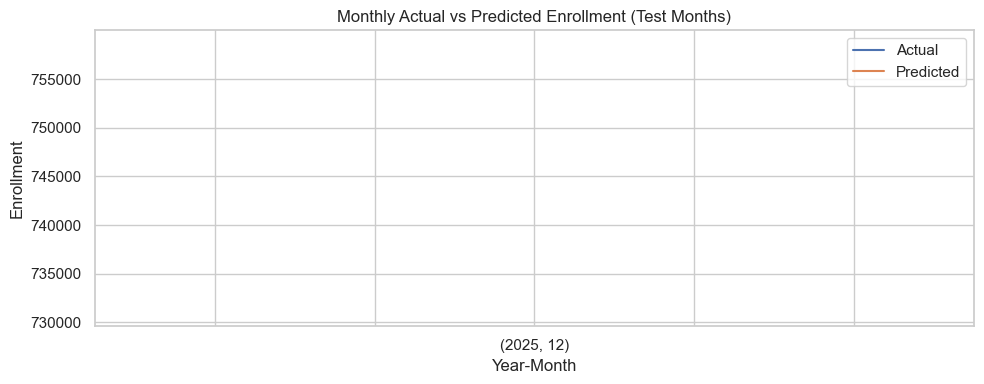

Saved plot to: S:\UIDAI_Hackathon\reports\monthly_actual_vs_pred.png

Feature importances:
district_state_ratio    2768
state_avg               2749
lag_1                   1186
rolling_mean_3          1096
lag_2                   1015
rolling_std_3            910
dtype: int32

Monthly forecast pipeline complete.

Feature importances:

Feature importances:
district_state_ratio    2768
state_avg               2749
lag_1                   1186
rolling_mean_3          1096
lag_2                   1015
rolling_std_3            910
dtype: int32
district_state_ratio    2768
state_avg               2749
lag_1                   1186
rolling_mean_3          1096
lag_2                   1015
rolling_std_3            910
dtype: int32


In [20]:
# Monthly Aadhaar Enrollment Forecasting (state-district-month)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(style='whitegrid')

# Paths
data_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv'
out_dir = r'S:\UIDAI_Hackathon\reports'
model_dir = r'S:\UIDAI_Hackathon\models'
os.makedirs(out_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'lgb_monthly.pkl')
pred_csv = os.path.join(out_dir, 'monthly_forecast_predictions.csv')
plot_path = os.path.join(out_dir, 'monthly_actual_vs_pred.png')

# Load base merged file (merging already done upstream)
df = pd.read_csv(data_path)
print('Loaded merged file rows:', len(df))

# --- Biometric-style cleaning applied here ---
# Parse date and drop invalid (handle DD-MM-YYYY by dayfirst)
# Try dayfirst parsing first; fallback to default parsing for remaining
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
# If some remain unparsed, try a second pass without dayfirst
mask_nat = df['date'].isna()
if mask_nat.any():
    df.loc[mask_nat, 'date'] = pd.to_datetime(df.loc[mask_nat, 'date'], errors='coerce')
# Drop rows with no valid date
df = df.dropna(subset=['date'])
print('After dropna(date) rows:', len(df))

# Ensure age columns exist and fill missing with 0
for col in ['age_0_5','age_5_17','age_18_greater']:
    if col not in df.columns:
        df[col] = 0
        print(f'Warning: missing column {col} - creating with zeros')
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Ensure categorical cols
df['state'] = df['state'].fillna('Unknown').astype(str).str.strip()
df['district'] = df['district'].fillna('Unknown').astype(str).str.strip()
# Pincode cleanup
if 'pincode' in df.columns:
    df['pincode'] = df['pincode'].astype(str).str.strip().str.zfill(6)
else:
    df['pincode'] = ''

# Drop exact duplicate rows (whole row match) early as in biometric.py
before_dup = len(df)
df = df.drop_duplicates()
after_dup = len(df)
print(f'Dropped exact duplicates: {before_dup - after_dup} rows')

# Filter invalid negative ages if any (keep only non-negative)
before_filter = len(df)
cond = (df['age_0_5'] >= 0) & (df['age_5_17'] >= 0) & (df['age_18_greater'] >= 0)
df = df[cond]
after_filter = len(df)
print(f'Filtered negative ages: {before_filter - after_filter} rows')

# Compute enrollment (per row)
df['enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Year / Month columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Aggregate to state-district-month (sums)
df_monthly = (
    df.groupby(['state','district','year','month'], dropna=False)['enrollment']
      .sum()
      .reset_index()
)
# create first-of-month date for time features
df_monthly['date'] = pd.to_datetime(df_monthly['year'].astype(int).astype(str) + '-' + df_monthly['month'].astype(int).astype(str) + '-01')

print('After aggregation (state-district-month) rows:', len(df_monthly), 'enrollment_sum:', df_monthly['enrollment'].sum())

# Sort for time-series operations
df_monthly = df_monthly.sort_values(['state','district','date']).reset_index(drop=True)

# Add biometric-like monthly features: shorter lags and rolling (prior months)
for lag in [1,2]:
    df_monthly[f'lag_{lag}'] = df_monthly.groupby(['state','district'])['enrollment'].shift(lag)

# rolling 3 months on prior months (use min_periods=1 to preserve early months)
df_monthly['rolling_mean_3'] = (
    df_monthly.groupby(['state','district'])['enrollment']
             .transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
)
df_monthly['rolling_std_3'] = (
    df_monthly.groupby(['state','district'])['enrollment']
             .transform(lambda x: x.shift(1).rolling(3, min_periods=1).std())
).fillna(0)

# Impute lag features conservatively to keep more rows: fill lag_2 from lag_1, and lag_1 from rolling_mean_3
# (This reduces NaNs caused by short histories for small districts)
df_monthly['lag_2'] = df_monthly['lag_2'].fillna(df_monthly['lag_1'])
df_monthly['lag_1'] = df_monthly['lag_1'].fillna(df_monthly['rolling_mean_3'])

# Feature list and diagnostics will consider the imputed values
# State context and ratio
df_monthly['state_avg'] = df_monthly.groupby(['state','date'])['enrollment'].transform('mean')
df_monthly['district_state_ratio'] = df_monthly['enrollment'] / (df_monthly['state_avg'] + 1e-9)

# Target
df_monthly['target_log'] = np.log1p(df_monthly['enrollment'])

# Diagnostics: how many NaNs per feature
feature_list = ['lag_1','lag_2','rolling_mean_3','rolling_std_3','state_avg','district_state_ratio']
na_counts = {f: int(df_monthly[f].isna().sum()) for f in feature_list}
print('NaN counts per feature (monthly):', na_counts)

# Prepare modeling dataset (drop rows missing features or target)
df_model = df_monthly.dropna(subset=feature_list + ['target_log']).copy()
print('Monthly modeling dataset shape (after dropna):', df_model.shape)
print('Enrollment sum raw -> monthly -> modeling:', df['enrollment'].sum(), df_monthly['enrollment'].sum(), df_model['enrollment'].sum())

# sample weight
df_model['sample_weight'] = np.sqrt(df_model['enrollment'].clip(lower=0))

# Save intermediate files for inspection
df_monthly.to_csv(os.path.join(out_dir, 'df_monthly_processed.csv'), index=False)
df_model.to_csv(os.path.join(out_dir, 'df_monthly_model_ready.csv'), index=False)
print('Saved df_monthly_processed.csv and df_monthly_model_ready.csv to reports for inspection')

# Continue with existing train/val/test split and modeling below (cells expect df_model)
features = ['lag_1','lag_2','rolling_mean_3','rolling_std_3','state_avg','district_state_ratio']

# 4) Train/Val/Test by month (as requested)
train_mask = df_model['month'].between(3,10)
val_mask = df_model['month'] == 11
test_mask = df_model['month'] == 12

X_train = df_model.loc[train_mask, features]
y_train = df_model.loc[train_mask, 'target_log']
w_train = df_model.loc[train_mask, 'sample_weight']
X_val = df_model.loc[val_mask, features]
y_val = df_model.loc[val_mask, 'target_log']
w_val = df_model.loc[val_mask, 'sample_weight']
X_test = df_model.loc[test_mask, features]
y_test = df_model.loc[test_mask, 'target_log']

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

if X_train.shape[0] < 10:
    print('Warning: very small training set; results may be unstable')

# 5) Train LightGBM (kept same as before)
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

if X_val.shape[0] > 0:
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        sample_weight=w_train,
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(50)]
    )
else:
    model.fit(X_train, y_train, sample_weight=w_train)

# save model
joblib.dump(model, model_path)
print('Saved LightGBM model to:', model_path)

# 6) Evaluate
if X_test.shape[0] > 0:
    pred_log = model.predict(X_test)
    pred = np.expm1(pred_log)
    true = np.expm1(y_test.values)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"Monthly RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Save predictions
    preds = df_model.loc[test_mask, ['state','district','year','month','enrollment']].copy()
    preds = preds.reset_index(drop=True)
    preds['pred_enrollment'] = pred
    preds['pred_log'] = pred_log
    preds.to_csv(pred_csv, index=False)
    print('Saved predictions to:', pred_csv)

    # Plot actual vs predicted aggregated by month (all districts)
    agg_true = preds.groupby(['year','month'])['enrollment'].sum()
    agg_pred = preds.groupby(['year','month'])['pred_enrollment'].sum()
    fig, ax = plt.subplots(figsize=(10,4))
    agg_true.plot(ax=ax, label='Actual')
    agg_pred.plot(ax=ax, label='Predicted')
    ax.set_title('Monthly Actual vs Predicted Enrollment (Test Months)')
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Enrollment')
    ax.legend()
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150)
    plt.show()
    print('Saved plot to:', plot_path)
else:
    print('No test months found for evaluation (need month=12 rows).')


# Feature importanceprint('\nMonthly forecast pipeline complete.')

# Feature importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print('\nFeature importances:')
print(importances)

print('\nMonthly forecast pipeline complete.')

importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print('\nFeature importances:')

print('\nFeature importances:')
print(importances)
print(importances)

In [6]:
# Quick check: load predictions and report test metrics
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

pred_csv = r'S:\UIDAI_Hackathon\reports\monthly_forecast_predictions.csv'
if os.path.exists(pred_csv):
    preds = pd.read_csv(pred_csv)
    print('Predictions file rows:', len(preds))
    if 'pred_enrollment' in preds.columns and 'enrollment' in preds.columns:
        rmse = mean_squared_error(preds['enrollment'], preds['pred_enrollment']) ** 0.5
        mae = mean_absolute_error(preds['enrollment'], preds['pred_enrollment'])
        print(f"Prediction file RMSE: {rmse:.2f}, MAE: {mae:.2f}")
        print('\nSample predictions:')
        print(preds.head(6).to_string(index=False))
    else:
        print('Prediction file missing columns (expected pred_enrollment, enrollment).')
else:
    print('Prediction CSV not found:', pred_csv)

# Confirm model file
model_path = r'S:\UIDAI_Hackathon\models\lgb_monthly.pkl'
print('\nModel path exists:', os.path.exists(model_path), model_path)

# List report files created
reports = [f for f in os.listdir(r'S:\UIDAI_Hackathon\reports') if 'monthly' in f or 'monthly_forecast' in f or 'district_clusters' in f]
print('\nReports saved (sample):', reports[:10])

Predictions file rows: 763
Prediction file RMSE: 13.91, MAE: 8.15

Sample predictions:
                      state                 district  year  month  enrollment  pred_enrollment  pred_log
Andaman And Nicobar Islands                 Andamans  2025     12           1         1.592459  0.952607
Andaman And Nicobar Islands                  Nicobar  2025     12           2         3.262297  1.449808
Andaman And Nicobar Islands North And Middle Andaman  2025     12           3         4.996407  1.791160
Andaman And Nicobar Islands            South Andaman  2025     12           4         5.411054  1.858024
             Andhra Pradesh    Alluri Sitharama Raju  2025     12          37        35.667824  3.601900
             Andhra Pradesh               Anakapalli  2025     12           8         8.239334  2.223470

Model path exists: True S:\UIDAI_Hackathon\models\lgb_monthly.pkl

Reports saved (sample): ['district_clusters.csv', 'district_clusters_scatter.png', 'monthly_actual_vs_pred.png

In [17]:
# Diagnostic: why so many rows dropped by dropna(date)
import pandas as pd
import os

df_raw = pd.read_csv(data_path, dtype={'date': str})
total_rows = len(df_raw)
null_dates = df_raw['date'].isna().sum()
empty_dates = (df_raw['date'].astype(str).str.strip() == '').sum()
print(f"Total rows in merged file: {total_rows}")
print(f"Empty-string dates: {empty_dates}, NaN dates: {null_dates}")

# Normalize and inspect problematic date strings
df_raw['date_str'] = df_raw['date'].astype(str).str.strip()
parsed = pd.to_datetime(df_raw['date_str'], errors='coerce')
fail_mask = parsed.isna()
fail_count = int(fail_mask.sum())
print(f"Rows where parsed date is NaT: {fail_count}")

if fail_count > 0:
    top_bad = df_raw.loc[fail_mask, 'date_str'].value_counts().head(30)
    print('\nTop invalid/malformed date strings (value:count):')
    print(top_bad.to_string())
    # Save a sample of failing rows for inspection
    sample_path = os.path.join(out_dir, 'date_parse_fail_sample.csv')
    df_raw.loc[fail_mask].sample(min(200, fail_count), random_state=42).to_csv(sample_path, index=False)
    print('\nSaved a sample of failing rows to:', sample_path)

# Quick check of date ranges for parsed rows
good = df_raw.loc[~fail_mask].copy()
if not good.empty:
    good['dt'] = pd.to_datetime(good['date_str'], errors='coerce')
    print('\nParsed date range:', good['dt'].min(), '->', good['dt'].max())
    print('Unique years in parsed dates (top 10):', sorted(good['dt'].dt.year.unique())[:10])

print('\nDiagnostic complete.')

Total rows in merged file: 973818
Empty-string dates: 0, NaN dates: 0
Rows where parsed date is NaT: 657006

Top invalid/malformed date strings (value:count):
date_str
15-12-2025    19127
30-10-2025    18040
22-12-2025    17643
19-11-2025    17182
15-11-2025    16960
17-10-2025    16786
31-12-2025    16511
18-11-2025    16134
25-11-2025    15456
31-10-2025    15180
13-10-2025    15057
16-09-2025    14848
18-10-2025    14746
18-09-2025    14540
15-09-2025    14216
19-09-2025    14209
24-09-2025    14191
23-12-2025    14015
29-12-2025    13991
15-10-2025    13984
17-09-2025    13901
16-11-2025    13883
19-10-2025    13825
25-09-2025    13765
25-10-2025    13510
13-09-2025    13491
20-09-2025    13458
24-12-2025    13278
23-09-2025    13272
14-11-2025    13222

Saved a sample of failing rows to: S:\UIDAI_Hackathon\reports\date_parse_fail_sample.csv

Parsed date range: 2025-01-04 00:00:00 -> 2025-12-11 00:00:00
Unique years in parsed dates (top 10): [np.int32(2025)]

Diagnostic complete.


In [21]:
# Diagnostics: why rows reduced / where data was dropped
import numpy as np

# Ensure df, df_monthly, df_model are present
if 'df' not in globals():
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df['enrollment'] = df['age_0_5'].fillna(0) + df['age_5_17'].fillna(0) + df['age_18_greater'].fillna(0)

print('Raw rows:', len(df))
print('Unique dates:', df['date'].nunique())
print('Date range:', df['date'].min(), '->', df['date'].max())
print('Unique state-district pairs:', df[['state','district']].drop_duplicates().shape[0])

# Monthly aggregation counts
if 'df_monthly' not in globals():
    df_monthly = df.groupby(['state','district',df['date'].dt.year, df['date'].dt.month])['enrollment'].sum().reset_index()
    df_monthly.columns = ['state','district','year','month','enrollment']

print('df_monthly rows:', len(df_monthly))
print('Years in df_monthly:', sorted(df_monthly['year'].unique()))

# How many district-month combos exist per district on average
dm_counts = df_monthly.groupby(['state','district']).size()
print('Median months per district:', dm_counts.median(), 'Mean months per district:', dm_counts.mean())

# How many rows dropped by feature NaNs in df_model
if 'df_model' in globals():
    print('df_model rows (after dropna on features):', len(df_model))
    dropped = len(df_monthly) - len(df_model)
    print('Rows dropped due to missing features:', dropped)
    # Which features are causing most NaNs
    na_counts = {col: df_monthly[col].isna().sum() for col in ['lag_1','lag_2','rolling_mean_3','rolling_std_3','state_avg','district_state_ratio']}
    print('Na counts in df_monthly:', na_counts)
    # For dropped rows, show top districts
    dropped_rows = df_monthly[df_monthly[features].isna().any(axis=1)]
    top_drop = dropped_rows.groupby('district').size().sort_values(ascending=False).head(10)
    print('\nTop 10 districts with most dropped months:')
    print(top_drop.to_string())
    if len(top_drop) > 0:
        sample_d = top_drop.index[0]
        print('\nSample rows for district (first 12 months):')
        print(df_monthly[df_monthly['district']==sample_d].sort_values(['year','month']).head(12).to_string())
else:
    print('df_model not found; run the main cell first')

# Totals check (enrollment sums)
print('\nTotal enrollment (raw):', df['enrollment'].sum())
print('Total enrollment (monthly aggregated):', df_monthly['enrollment'].sum())
if 'df_model' in globals():
    print('Total enrollment (after feature drop):', df_model['enrollment'].sum())

# Check for unexpected filtering (month selection)
print('\nMonths present in df_model:', sorted(df_model['month'].unique()))
print('Years present in df_model:', sorted(df_model['year'].unique()))

print('\nDiagnostics complete.')

Raw rows: 973807
Unique dates: 92
Date range: 2025-03-02 00:00:00 -> 2025-12-31 00:00:00
Unique state-district pairs: 790
df_monthly rows: 4207
Years in df_monthly: [np.int32(2025)]
Median months per district: 5.0 Mean months per district: 5.3253164556962025
df_model rows (after dropna on features): 3417
Rows dropped due to missing features: 790
Na counts in df_monthly: {'lag_1': np.int64(790), 'lag_2': np.int64(790), 'rolling_mean_3': np.int64(790), 'rolling_std_3': np.int64(0), 'state_avg': np.int64(0), 'district_state_ratio': np.int64(0)}

Top 10 districts with most dropped months:
district
Adilabad       1
Agar Malwa     1
Agra           1
Ahilyanagar    1
Ahmedabad      1
Ahmednagar     1
Aizawl         1
Ajmer          1
Akola          1
Alappuzha      1

Sample rows for district (first 12 months):
          state  district  year  month  enrollment       date   lag_1   lag_2  rolling_mean_3  rolling_std_3    state_avg  district_state_ratio  target_log
3318  Telangana  Adilabad  2